# USA Baby Name Analysis from 1910 to 2015

# Import Libraries

In [1]:
%autosave 240

Autosaving every 240 seconds


In [2]:
import pandas as pd
from collections import OrderedDict
import math
import numpy as np
import pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from sklearn.feature_selection import VarianceThreshold
from scipy.interpolate import interp1d

D:\Python\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Raw data from CSV

In [3]:
# read the data (NationalName.csv) from csv format
nn = pd.read_csv("NationalNames.csv")
# Discard nn data before 1910
nn = nn.query('Year>=1910').drop('Id', axis=1)
nn = nn.drop('Gender', axis=1)
# show sample data
print(nn.head())


           Name  Year  Count
88943      Mary  1910  22848
88944     Helen  1910  10479
88945  Margaret  1910   8226
88946   Dorothy  1910   7318
88947      Ruth  1910   7212



# Preprocess Raw Data


Weight Data with log-TF

In [4]:
list_of_names = sorted(nn.Name.unique())
num_unique_names = len(list_of_names)
num_years = len(nn.Year.unique())
tf_template = dict.fromkeys(list_of_names, 0)
tf_template = OrderedDict(sorted(tf_template.items(), key=lambda t: t[0]))
print("Shape of data:", num_years,",", num_unique_names)

Shape of data: 105 , 93805


In [5]:
# Retrieve Raw Name Count data && generate weighted TF score
nn_groupByYear = nn.groupby('Year')
tfs = []
wtfs = []
for year,group in nn_groupByYear:
    tf = tf_template.copy()
    wtf = tf_template.copy()
    for index, row in group.iterrows():
        # ignore gender for now, plus would work just fine
        tf[row['Name']] = tf[row['Name']] + row['Count']
    for k,v in tf.items():
        if v == 0:
            wtf[k] = 1
        else:
            wtf[k] = 1 + np.log(v)
    tfs.append(tf)
    wtfs.append(wtf)

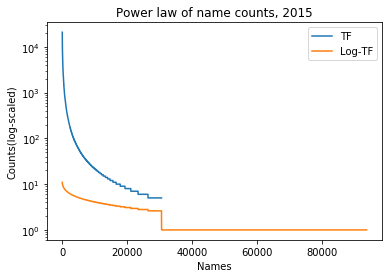

In [6]:
some_tf = np.array(sorted(tfs[-1].items(), key=lambda t: t[1], reverse=True))
some_wtf = np.array(sorted(wtfs[-1].items(), key=lambda t: t[1], reverse=True))

plt.plot(range(len(some_tf)),((some_tf[:,1]).astype(int)), label='TF')
plt.plot(range(len(some_wtf)),((some_wtf[:,1]).astype(float)), label='Log-TF')
plt.yscale('log')
plt.title("Power law of name counts, 2015")
plt.ylabel("Counts(log-scaled)")
plt.xlabel("Names")
plt.legend()
plt.show()


# Visualize Raw Data

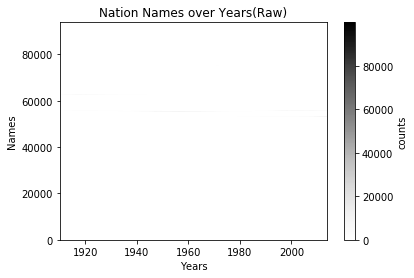

In [7]:
# Plot the density graph of tfs
y = range(num_unique_names)
x = range(1910, 2015)
z = np.array([[v for k,v in tf.items()] for tf in tfs])
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,z.transpose(), cmap=plt.cm.Greys)
plt.colorbar(label='counts')
plt.title("Nation Names over Years(Raw)")
plt.xlabel("Years")
plt.ylabel("Names")
plt.show()

# Visualize Weighted Data

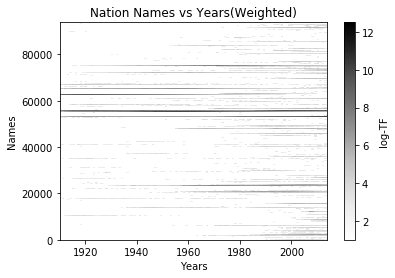

In [8]:
# Plot the density graph of tfs
y = range(num_unique_names)
x = range(1910, 2015)
wz = np.array([[v for k,v in wtf.items()] for wtf in wtfs])
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,wz.transpose(), cmap=plt.cm.Greys)
plt.colorbar(label='log-TF')
plt.title("Nation Names vs Years(Weighted)")
plt.xlabel("Years")
plt.ylabel("Names")
plt.show()

# Define helper functions

In [9]:
# This Functino is modified from "How to Convert a Time Series to a Supervised Learning Problem in Python"
# "https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/"
# Purpose of this function is to convert time series data into data suitable for supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [10]:
score_metric = [0.25, 0.2, 0.15, 0.11, 0.09, 0.06, 0.05, 0.04, 0.03, 0.02]
tk = len(score_metric)

# This function computes the accuracy score of the prediction result
def get_accuracy_score(y, y_hat):
    y_t = sorted(range(len(y)), key=lambda i: y[i], reverse=True)[:tk]
    y_hat_t = sorted(range(len(y_hat)), key=lambda i: y_hat[i], reverse=True)[:tk]
    score = 0
    for i in range(tk):
        if y_t[i] == y_hat_t[i]:
            score = score + 0.8 * score_metric[i]
        if y_hat_t[i] in y_t:
            score = score + 0.2 * 1/tk
    return score
    

# Multivariate LSTM-RNN Model

Implement a LSTM rnn model to process name count as time series data

In [11]:
n_years_back = 5
n_features = num_unique_names

In [12]:
# put processed data back to dataframe
dataset = pd.DataFrame(wz)
print(dataset.shape)

# normalize features using scaler to (0,1)
scaler = StandardScaler()
scaled = scaler.fit_transform(dataset)

# adapt data for supervised learning
adapted = series_to_supervised(scaled, n_years_back, 1)
print(adapted.shape)

(105, 93805)
(100, 562830)


In [13]:
# split data into train and test sets
train_ratio = 0.633
num_train = int(train_ratio * adapted.shape[0])

values = adapted.values
train = values[:num_train, :]
test = values[num_train:, :]

n_obs = n_years_back * n_features
train_X_o, train_y_o = train[:, :n_obs], train[:, -n_features:]
test_X_o, test_y_o = test[:, :n_obs], test[:, -n_features:]
print(train_X_o.shape, len(train_X_o), test_y_o.shape)

(63, 469025) 63 (37, 93805)


In [14]:
# reshape data to 3d
train_X = train_X_o.reshape((train_X_o.shape[0], n_years_back, n_features))
test_X = test_X_o.reshape((test_X_o.shape[0], n_years_back, n_features))

train_y = train_y_o
test_y = test_y_o

# train_y = train_y_o.reshape(train_y_o.shape[0], 1, n_features)
# test_y = test_y.reshape(test_y.shape[0], 1, n_features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(63, 5, 93805) (63, 93805) (37, 5, 93805) (37, 93805)


In [15]:
# model 
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_features))
adam = optimizers.Adam(lr=0.001)

model.compile(loss='mae', optimizer=adam)

In [16]:
%%time
# fir model
# silence the training process for simplicity
result = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 63 samples, validate on 37 samples
Epoch 1/100
63/63 [==============================] - 6s 91ms/step - loss: 0.4014 - val_loss: 0.7330
Epoch 2/100
63/63 [==============================] - 2s 28ms/step - loss: 0.3876 - val_loss: 0.7324
Epoch 3/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3638 - val_loss: 0.7302
Epoch 4/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3369 - val_loss: 0.7289
Epoch 5/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3125 - val_loss: 0.7273
Epoch 6/100
63/63 [==============================] - 2s 28ms/step - loss: 0.2933 - val_loss: 0.7256
Epoch 7/100
63/63 [==============================] - 2s 29ms/step - loss: 0.2762 - val_loss: 0.7243
Epoch 8/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2603 - val_loss: 0.7233
Epoch 9/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2461 - val_loss: 0.7224
Epoch 10/100
63/63 [==============================] - 2s

Epoch 82/100
63/63 [==============================] - 2s 30ms/step - loss: 0.1505 - val_loss: 0.7147
Epoch 83/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1498 - val_loss: 0.7147
Epoch 84/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1495 - val_loss: 0.7147
Epoch 85/100
63/63 [==============================] - 2s 26ms/step - loss: 0.1493 - val_loss: 0.7147
Epoch 86/100
63/63 [==============================] - 2s 30ms/step - loss: 0.1492 - val_loss: 0.7146
Epoch 87/100
63/63 [==============================] - 2s 27ms/step - loss: 0.1490 - val_loss: 0.7146
Epoch 88/100
63/63 [==============================] - 2s 27ms/step - loss: 0.1490 - val_loss: 0.7145
Epoch 89/100
63/63 [==============================] - 2s 28ms/step - loss: 0.1488 - val_loss: 0.7144
Epoch 90/100
63/63 [==============================] - 2s 29ms/step - loss: 0.1487 - val_loss: 0.7144
Epoch 91/100
63/63 [==============================] - 2s 28ms/step - loss: 0.1485 - val_los

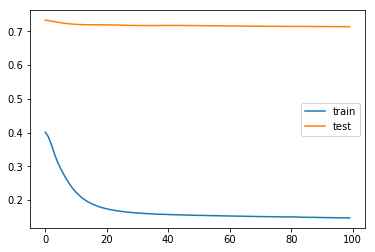

In [17]:
# plot loss over epochs
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# model.get_config()

In [19]:
# make a prediction for test set
test_yhat = model.predict(test_X)

test_X_s = test_X.reshape((test_X.shape[0], n_years_back * n_features))
# invert scaling for prediction
test_inv_yhat = scaler.inverse_transform(test_yhat)
# invert scaling for actual
test_inv_y = scaler.inverse_transform(test_y)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_inv_y, test_inv_yhat))
print('Test RMSE: %.4f' % rmse)

# make a prediction for train set
train_yhat = model.predict(train_X)
train_X_s = train_X.reshape((train_X.shape[0], n_years_back * n_features))
# invert scaling for prediction
train_inv_yhat = scaler.inverse_transform(train_yhat)
# invert scaling for actual
train_inv_y = scaler.inverse_transform(train_y)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_inv_y, train_inv_yhat))
print('Train RMSE: %.4f' % rmse)

Test RMSE: 1.0608
Train RMSE: 0.4819


In [20]:
# sample comparison
n_top = 5

for itr in range(1,3):
    year = 2015 - itr
    print('Year of ', year, ':')
    # load truth and prediction into dict
    d = {}
    d_hat = {}
    for i in range(n_features):
        d[list_of_names[i]] = wz[-itr][i]
        d_hat[list_of_names[i]] = test_inv_yhat[-itr][i]
    truth = list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))
    pred = list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))
    
    print('Truth:      ', truth[0][:n_top])
#    print('Truth:      ', list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])
    print('Prediction: ', pred[0][:n_top])
#    print('Prediction: ', list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])

Year of  2014 :
Truth:       ('Emma', 'Olivia', 'Noah', 'Sophia', 'Liam')
Prediction:  ('James', 'John', 'Robert', 'William', 'Mary')
Year of  2013 :
Truth:       ('Sophia', 'Emma', 'Olivia', 'Noah', 'Liam')
Prediction:  ('James', 'John', 'Robert', 'William', 'Mary')


(100, 93805)


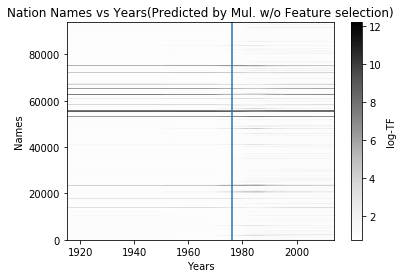

In [21]:
# plot predicted data
z_hat = np.concatenate((train_inv_yhat, test_inv_yhat))
print(z_hat.shape)

# Plot the density graph of tfs
y = range(num_unique_names)
x = range(1910+n_years_back, 2015)
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,z_hat.transpose(), cmap=plt.cm.Greys)
plt.colorbar(label='log-TF')
plt.title("Nation Names vs Years(Predicted by Mul. w/o Feature selection)")
plt.xlabel("Years")
plt.ylabel("Names")
plt.axvline(x=1910+int(train_ratio*num_years))
plt.show()

In [22]:
train_inv_yhat_m1 = train_inv_yhat
train_inv_y_m1 = train_inv_y
test_inv_yhat_m1 = test_inv_yhat
test_inv_y_m1 = test_inv_y

[0.32 0.34 0.32 0.32 0.32 0.35 0.35 0.35 0.35 0.48 0.51 0.58 0.6  0.6
 0.81 0.85 0.49 0.85 0.85 0.78 0.39 0.34 0.37 0.37 0.55 0.48 0.52 0.43
 0.37 0.37 0.37 0.37 0.29 0.25 0.25 0.41 0.28 0.28 0.52 0.35 0.19 0.35
 0.32 0.16 0.16 0.16 0.28 0.28 0.16 0.16 0.16 0.14 0.14 0.26 0.12 0.12
 0.12 0.39 0.32 0.37 0.3  0.32 0.34 0.36 0.32 0.32 0.3  0.28 0.3  0.3
 0.28 0.28 0.26 0.04 0.04 0.04 0.06 0.02 0.02 0.02 0.02 0.   0.   0.
 0.02 0.02 0.02 0.02 0.02 0.   0.   0.   0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]


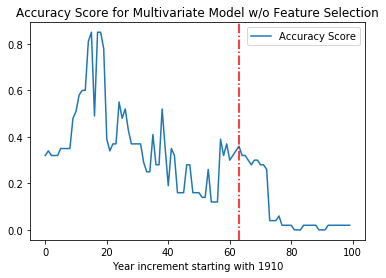

In [23]:
# compute and plot scores of test set
scores = []

final_truth = np.concatenate((train_inv_y, test_inv_y))
final_result = np.concatenate((train_inv_yhat, test_inv_yhat))

for i in range(len(adapted)):
    # global_index = n_years_back + num_train + i
    scores.append( get_accuracy_score(final_truth[i], final_result[i]))

print(np.round(scores, 2))
plt.plot(np.round(scores, 2), label='Accuracy Score')
plt.axvline(x=num_train, linestyle='-.', color='r')
plt.title('Accuracy Score for Multivariate Model w/o Feature Selection')
plt.xlabel('Year increment starting with 1910')
plt.legend()
plt.show()

In [24]:
print(np.mean(scores[:num_train]), np.mean(scores[num_train:]))

0.3706031746031747 0.09502702702702705


# Feature Selection
There are lots of names that appear only a few times and does not has impact on training process, maybe we could ignore them when training the model to alleviate the curse of demensionality

Few possibilities:
1. ~~PCA (OOM)~~
2. Remove features with low variance
3. ~~Mutual information~~(shouldn't change much)

In [25]:
variance_threshold = 0.5

In [26]:
dataset_v = dataset.values[:, :]
print(dataset_v.shape)

(105, 93805)


In [27]:
# apply variance filter
vt_selector = VarianceThreshold(threshold=variance_threshold)
vt_selector.fit(dataset_v)
var_idx = [ i for (i, v) in enumerate(vt_selector.variances_) if v < variance_threshold]
print(len(var_idx))

61950


In [28]:
# apply mean filter
sum = dataset_v.sum(axis=0)/num_years
print(sum)
k = int(0.63 * n_features)
mean_idx = np.argpartition(sum, k)[:k]
print(len(mean_idx))

[1.15053199 1.05478641 1.01532798 ... 1.01706438 1.01706438 1.01532798]
59097


In [29]:
remove_idx = list(set(mean_idx).intersection(set(var_idx)))
print(len(remove_idx))
n_features_r = n_features - len(remove_idx)

58756


In [30]:
# modify list of name
list_of_names_fs = np.delete(list_of_names, remove_idx, axis=0)
print(len(list_of_names_fs))

35049


In [31]:
# remove irrelevant features
dataset_v_fs = np.delete(dataset_v, remove_idx, axis=1)

# normalize features using scaler to (0,1)
scaler2 = StandardScaler()
scaled2 = scaler2.fit_transform(dataset_v_fs)

# adapt data for supervised learning
adapted2 = series_to_supervised(scaled2, n_years_back, 1)
print(adapted2.shape)

(100, 210294)


In [32]:
# test again with model
train_ratio = 0.633
num_train = int(train_ratio * adapted2.shape[0])

values = adapted2.values
train = values[:num_train, :]
test = values[num_train:, :]

n_obs = n_years_back * n_features_r
train_X_o, train_y_o = train[:, :n_obs], train[:, -n_features_r:]
test_X_o, test_y_o = test[:, :n_obs], test[:, -n_features_r:]
print(train_X_o.shape, len(train_X_o), test_y_o.shape)

(63, 175245) 63 (37, 35049)


In [33]:
# reshape data to 3d
train_X = train_X_o.reshape((train_X_o.shape[0], n_years_back, n_features_r))
test_X = test_X_o.reshape((test_X_o.shape[0], n_years_back, n_features_r))

train_y = train_y_o
test_y = test_y_o

# train_y = train_y_o.reshape(train_y_o.shape[0], 1, n_features)
# test_y = test_y.reshape(test_y.shape[0], 1, n_features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(63, 5, 35049) (63, 35049) (37, 5, 35049) (37, 35049)


In [34]:
# model 
model2 = Sequential()
model2.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(n_features_r))
model2.compile(loss='mae', optimizer=adam)

In [35]:
%%time
# fir model
# silence the training process for simplicity
result = model2.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 63 samples, validate on 37 samples
Epoch 1/100
63/63 [==============================] - 2s 38ms/step - loss: 0.6721 - val_loss: 1.0776
Epoch 2/100
63/63 [==============================] - 1s 10ms/step - loss: 0.6327 - val_loss: 1.0764
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 0.5730 - val_loss: 1.0737
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 0.5006 - val_loss: 1.0694
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: 0.4313 - val_loss: 1.0666
Epoch 6/100
63/63 [==============================] - 1s 10ms/step - loss: 0.3953 - val_loss: 1.0655
Epoch 7/100
63/63 [==============================] - 1s 10ms/step - loss: 0.3845 - val_loss: 1.0657
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: 0.3742 - val_loss: 1.0657
Epoch 9/100
63/63 [==============================] - 1s 10ms/step - loss: 0.3579 - val_loss: 1.0657
Epoch 10/100
63/63 [==============================] - 1s

Epoch 82/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2135 - val_loss: 1.0283
Epoch 83/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2131 - val_loss: 1.0282
Epoch 84/100
63/63 [==============================] - 1s 12ms/step - loss: 0.2127 - val_loss: 1.0282
Epoch 85/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2123 - val_loss: 1.0281
Epoch 86/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2120 - val_loss: 1.0280
Epoch 87/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2116 - val_loss: 1.0280
Epoch 88/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2114 - val_loss: 1.0279
Epoch 89/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2111 - val_loss: 1.0279
Epoch 90/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2108 - val_loss: 1.0278
Epoch 91/100
63/63 [==============================] - 1s 10ms/step - loss: 0.2105 - val_los

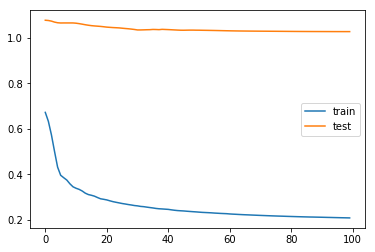

In [36]:
# plot loss over epochs
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
# make a prediction for test set
test_yhat = model2.predict(test_X)

test_X_s = test_X.reshape((test_X.shape[0], n_years_back * n_features_r))
# invert scaling for prediction
test_inv_yhat = scaler2.inverse_transform(test_yhat)
# invert scaling for actual
test_inv_y = scaler2.inverse_transform(test_y)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_inv_y, test_inv_yhat))
print('Test RMSE: %.4f' % rmse)

# make a prediction for train set
train_yhat = model2.predict(train_X)
train_X_s = train_X.reshape((train_X.shape[0], n_years_back * n_features_r))
# invert scaling for prediction
train_inv_yhat = scaler2.inverse_transform(train_yhat)
# invert scaling for actual
train_inv_y = scaler2.inverse_transform(train_y)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_inv_y, train_inv_yhat))
print('Train RMSE: %.4f' % rmse)

Test RMSE: 1.5437
Train RMSE: 0.5486


In [38]:
# sample comparison
n_top = 5

# print(np.where(list_of_names_fs == "Emma"))

for itr in range(1,3):
    year = 2015 - itr
    print('Year of ', year, ':')
    # load truth and prediction into dict
    d = {}
    d_hat = {}
    for i in range(n_features_r):
        d[list_of_names_fs[i]] = test_inv_y[-itr][i]
        d_hat[list_of_names_fs[i]] = test_inv_yhat[-itr][i]
    print('Truth:      ', list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))[0][:n_top])
#    print('Truth:      ', list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])
    print('Prediction: ', list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))[0][:n_top])
#    print('Prediction: ', list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])

Year of  2014 :
Truth:       ('Emma', 'Olivia', 'Noah', 'Sophia', 'Liam')
Prediction:  ('James', 'John', 'Robert', 'William', 'Mary')
Year of  2013 :
Truth:       ('Sophia', 'Emma', 'Olivia', 'Noah', 'Liam')
Prediction:  ('James', 'John', 'Robert', 'William', 'Mary')


In [39]:
train_inv_yhat_m1fs = train_inv_yhat
train_inv_y_m1fs = train_inv_y
test_inv_yhat_m1fs = test_inv_yhat
test_inv_y_m1fs = test_inv_y

[0.41 0.43 0.41 0.43 0.43 0.34 0.34 0.34 0.34 0.64 0.64 0.8  0.82 0.86
 0.65 0.65 0.27 0.61 0.61 0.66 0.18 0.25 0.23 0.25 0.37 0.42 0.37 0.49
 0.52 0.42 0.46 0.4  0.35 0.32 0.35 0.16 0.28 0.28 0.5  0.3  0.16 0.25
 0.16 0.16 0.2  0.24 0.19 0.16 0.43 0.43 0.47 0.84 0.84 0.63 0.86 0.66
 0.52 0.38 0.38 0.34 0.34 0.5  0.59 0.34 0.34 0.32 0.32 0.32 0.32 0.32
 0.3  0.32 0.3  0.06 0.08 0.04 0.06 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.04 0.04 0.04 0.07 0.04 0.02 0.02 0.02 0.04 0.04 0.04 0.04 0.04 0.02
 0.02 0.02]


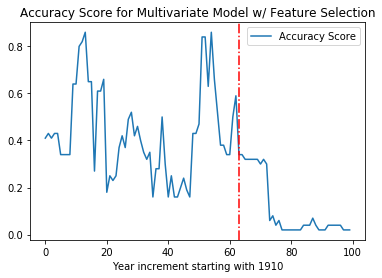

In [40]:
# compute and plot scores of test set
scores = []

final_truth = np.concatenate((train_inv_y, test_inv_y))
final_result = np.concatenate((train_inv_yhat, test_inv_yhat))

for i in range(len(adapted)):
    # global_index = n_years_back + num_train + i
    scores.append( get_accuracy_score(final_truth[i], final_result[i]))

print(np.round(scores, 2))
plt.plot(np.round(scores, 2), label='Accuracy Score')
plt.axvline(x=num_train, linestyle='-.', color='r')
plt.title('Accuracy Score for Multivariate Model w/ Feature Selection')
plt.xlabel('Year increment starting with 1910')
plt.legend()
plt.show()



In [41]:
print(np.mean(scores[:num_train]), np.mean(scores[num_train:]))

0.43333333333333346 0.11167567567567567


(100, 35049)


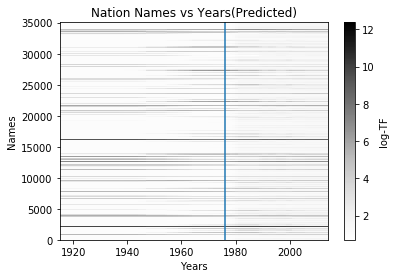

In [42]:
# plot predicted data
z_hat = np.concatenate((train_inv_yhat, test_inv_yhat))
print(z_hat.shape)

# Plot the density graph of tfs
y = range(n_features_r)
x = range(1910+n_years_back, 2015)
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,z_hat.transpose(), cmap=plt.cm.Greys)
plt.colorbar(label='log-TF')
plt.title("Nation Names vs Years(Predicted by Mul. w/ Feature selection)")
plt.xlabel("Years")
plt.ylabel("Names")
plt.axvline(x=1910+int(train_ratio*num_years))
plt.show()

# Independent Univariate LSTM-RNN Model
#### In multivariate model we suffer from the curse of dimensionality
#### Hopefully we can solve it by using repeated independent univariate model

In [43]:
# Process Data the same way as in Model 1

In [44]:
# put processed data back to dataframe
dataset = pd.DataFrame(wz)
print(dataset.shape)

# normalize features using scaler to (0,1)
scaler3 = StandardScaler()
scaled3 = scaler3.fit_transform(dataset)

# adapt data for supervised learning
adapted3 = series_to_supervised(scaled3, n_years_back, 1)
print(adapted.shape)

(105, 93805)
(100, 562830)


In [45]:
# split data into train and test sets
train_ratio = 0.633
num_train = int(train_ratio * adapted3.shape[0])

values = adapted3.values
train = values[:num_train, :]
test = values[num_train:, :]

n_obs = n_years_back * n_features
train_X_o, train_y_o = train[:, :n_obs], train[:, -n_features:]
test_X_o, test_y_o = test[:, :n_obs], test[:, -n_features:]
print(train_X_o.shape, len(train_X_o), test_y_o.shape)

(63, 469025) 63 (37, 93805)


In [46]:
# reshape data to 3d
train_X = train_X_o.reshape((train_X_o.shape[0], n_years_back, n_features))
test_X = test_X_o.reshape((test_X_o.shape[0], n_years_back, n_features))

train_y = train_y_o
test_y = test_y_o

# train_y = train_y_o.reshape(train_y_o.shape[0], 1, n_features)
# test_y = test_y.reshape(test_y.shape[0], 1, n_features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(63, 5, 93805) (63, 93805) (37, 5, 93805) (37, 93805)


In [ ]:
%%time
# fir model
# silence the training process for simplicity
test_yhat = []
train_yhat = []
loss = []
val_loss = []

# model 
model = Sequential()
model.add(LSTM(2, input_shape=(train_X.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mae', optimizer=adam)

n_epoch = 50

for n in range(n_features):
    train_X_row = train_X[:,:,n]
    train_y_row = train_y[:,n]
    test_X_row = test_X[:,:,n]
    test_y_row = test_y[:,n]
    
    train_X_row = train_X_row.reshape((train_X.shape[0], train_X.shape[1], 1))
    train_y_row = train_y_row.reshape((train_y.shape[0], 1))
    test_X_row = test_X_row.reshape((test_X.shape[0], test_X.shape[1], 1))
    test_y_row = test_y_row.reshape((test_y.shape[0], 1))
    
    if n % 5000 == 0: 
        print("processing idx :", n)
    result = model.fit(train_X_row, train_y_row, epochs=n_epoch, batch_size=32, validation_data=(test_X_row, test_y_row), verbose=0, shuffle=False)
    loss.append(result.history['loss'])
    val_loss.append(result.history['val_loss'])
    test_yhat.append(model.predict(test_X_row))
    train_yhat.append(model.predict(train_X_row))
    

processing idx : 0
processing idx : 5000
processing idx : 10000
processing idx : 15000
processing idx : 20000
processing idx : 25000
processing idx : 30000
processing idx : 35000


In [ ]:
test_yhat_reshape = np.array(test_yhat)
train_yhat_reshape = np.array(train_yhat)

test_yhat_reshape = test_yhat_reshape.reshape(test_y.shape)
train_yhat_reshape = train_yhat_reshape.reshape(train_y.shape)
print(test_yhat_reshape.shape, train_yhat_reshape.shape)

In [ ]:
loss_np = np.array(loss)
val_loss_np = np.array(val_loss)

loss_np = loss_np.reshape((n_epoch, n_features))
val_loss_np = val_loss_np.reshape((n_epoch, n_features))

print(loss_np.shape, val_loss_np.shape)

In [ ]:
# plot loss over epochs
loss_np = loss_np.sum(axis=1)/n_features
val_loss_np = val_loss_np.sum(axis=1)/n_features

plt.plot(loss_np, label='train')
plt.plot(val_loss_np, label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction for test set
# test_yhat = model.predict(test_X)
test_yhat_reshape
train_yhat_reshape

test_X_s = test_X.reshape((test_X.shape[0], n_years_back * n_features))
# invert scaling for prediction
test_inv_yhat = scaler3.inverse_transform(test_yhat_reshape)
# invert scaling for actual
test_inv_y = scaler3.inverse_transform(test_y)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_inv_y, test_inv_yhat))
print('Test RMSE: %.4f' % rmse)

# make a prediction for train set
train_X_s = train_X.reshape((train_X.shape[0], n_years_back * n_features))
# invert scaling for prediction
train_inv_yhat = scaler3.inverse_transform(train_yhat_reshape)
# invert scaling for actual
train_inv_y = scaler3.inverse_transform(train_y)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_inv_y, train_inv_yhat))
print('Train RMSE: %.4f' % rmse)

In [ ]:
# sample comparison
n_top = 5

for itr in range(1,3):
    year = 2015 - itr
    print('Year of ', year, ':')
    # load truth and prediction into dict
    d = {}
    d_hat = {}
    for i in range(n_features_r):
        d[list_of_names[i]] = test_inv_y[-itr][i]
        d_hat[list_of_names[i]] = test_inv_yhat[-itr][i]
    print('Truth:      ', list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))[0][:n_top])
#    print('Truth:      ', list(zip(*sorted(d.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])
    print('Prediction: ', list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))[0][:n_top])
#    print('Prediction: ', list(zip(*sorted(d_hat.items(), key=lambda t: t[1], reverse=True)))[1][:n_top])

In [ ]:
train_inv_yhat_i = train_inv_yhat
train_inv_y_i = train_inv_y
test_inv_yhat_i = test_inv_yhat
test_inv_y_i = test_inv_y

In [ ]:
# compute and plot scores of test set
scores = []

final_truth = np.concatenate((train_inv_y, test_inv_y))
final_result = np.concatenate((train_inv_yhat, test_inv_yhat))

for i in range(len(adapted)):
    # global_index = n_years_back + num_train + i
    scores.append( get_accuracy_score(final_truth[i], final_result[i]))

print(np.round(scores, 2))
plt.plot(np.round(scores, 2), label='Accuracy Score')
plt.axvline(x=num_train, linestyle='-.', color='r')
plt.title('Accuracy Score for Independent Model')
plt.xlabel('Year increment starting with 1910')
plt.legend()
plt.show()

In [ ]:
# plot predicted data
z_hat = np.concatenate((train_inv_yhat, test_inv_yhat))
print(z_hat.shape)

# Plot the density graph of tfs
y = range(num_unique_names)
x = range(1910+n_years_back, 2015)
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,z_hat.transpose(), cmap=plt.cm.Greys)
plt.colorbar(label='log-TF')
plt.title("Nation Names vs Years(Predicted by Ind.)")
plt.xlabel("Years")
plt.ylabel("Names")
plt.axvline(x=1910+int(train_ratio*num_years), linestyle='-.')
plt.show()